In [1]:
import numpy as np
from numba import jit
from glob import glob
from matplotlib import pyplot as plt

% matplotlib inline

In [2]:
name = glob('_data/ATSC-500/aircraft.npz')
print(name)
data = np.load(name[0])
wvel = data['wvel']
wvel = wvel - np.mean(wvel)

['_data/ATSC-500/aircraft.npz']


In [3]:
def calc_window(numvals=1440):
    """
      Calculate a Bartlett window following
      Numerical Recipes 13.4.13
      -------------------------------------
      From [https://clouds.eos.ubc.ca/~phil/courses/atsc500/html/strfun_fft.html]
    """
    
    halfpoint=int(np.floor(numvals/2.))
    facm=halfpoint
    facp=1/facm
    window=np.empty([numvals],np.float)
    for j in np.arange(numvals):
        window[j]=(1.-((j - facm)*facp)**2.)
    return window

def Bartlett_FFT(data, window, R=25):
    L = len(window)
    S0 = np.zeros(L)
    W = (window**2.).sum()/L
    subset = data[:L*R]
    subset = subset.reshape((R, L))
    for i in range(R):
        fft_val = np.fft.fft(subset[i, :]*window)
        S = np.real(fft_val*np.conj(fft_val))
        S0 += S
    S0 = S0/(L**2.*R*W)
    ind_mid = int(.5*len(S0))
    return S0[1:ind_mid], ind_mid 

from scipy.optimize import curve_fit

def A53_fit(k, b):
    return 10**(b - (5/3)*np.log10(k))

Based on the Kolmogoroff's scaling law, the dissipation rate can be estimated as follows:

$$
\epsilon = \left[\frac{S_i\left(k\right)k^{\frac{5}{3}}}{A_i}\right]^\frac{3}{2}
$$

Where $S$ is the spectural power, $k$ is the wavenumber, $i$ is one of the $\left\{U, V, W\right\}$, for vertical velosity, $A_w = 0.667$

In this case, After the spectural power and wavenumber were calculated, the intercept was fitted with a fix slope of $-5/3$, and $S$ was picked with any wavenumber along the line. 

In [4]:
R = 25 # sampling rate
L = 1440 # window length
window = calc_window(numvals=L)
S0, ind_mid = Bartlett_FFT(wvel, window, R)
k = (2*np.pi*np.linspace(0, 1, ind_mid)*(R/2.))[1:] # avoid the first element
b, _ = curve_fit(A53_fit, k[1:], S0[1:])
A53 = A53_fit(k, b)
# dissipation
epsilon = (((A53*k**(5/3))/0.667)**1.5)[0]

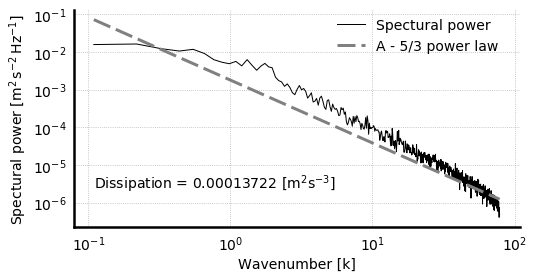

In [5]:
fig =plt.figure(figsize=(8, 4))
ax = fig.gca()
ax.grid(linestyle=':')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[j.set_linewidth(2.5) for j in ax.spines.values()]
ax.tick_params(axis="both", which="both", bottom="off", top="off", \
           labelbottom="on", left="off", right="off", labelleft="on")
ax.set_xlabel('Wavenumber [k]', fontsize=14)
ax.set_ylabel('Spectural power [$\mathrm{m^2\,s^{-2}\,Hz^{-1}}$]', fontsize=14)
ax.text(1.1e-1, 2.5e-6, 'Dissipation = {} '.format(np.around(epsilon, 8))+'[$\mathrm{m^2s^{-3}}$]', fontsize=14)
ax.loglog(k, S0, 'k-', lw=1, label='Spectural power')
ax.loglog(k, A53, color='gray', dashes=(6,2), lw=3, label='A - 5/3 power law')
LG = ax.legend(bbox_to_anchor=(0.98, 1.02), prop={'size':14}); LG.draw_frame(False)
 